In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from dataset import get_manchester

In [197]:
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}


In [3]:
unigrams, bigrams, trigrams = get_manchester("/home/paul/corpora/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

In [186]:
def proportion_difference(a, b):
    a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    return (a - b).abs().sum()

def num_zeros(child, adult):
    child, adult = child.align(adult)
    return pd.Series({'CHI': len(child[np.isnan(child)]),
                      'MOT': len(adult[np.isnan(adult)])})
 

def difference_child_adult(df):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return proportion_difference(child, adult)

def zeros_child_adult(df):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return num_zeros(child, adult)

def vvv_format(title='', ylabel='', autoscale=False, max=1):

    plt.grid()
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()

# Proportion of shared ngram types by speaker

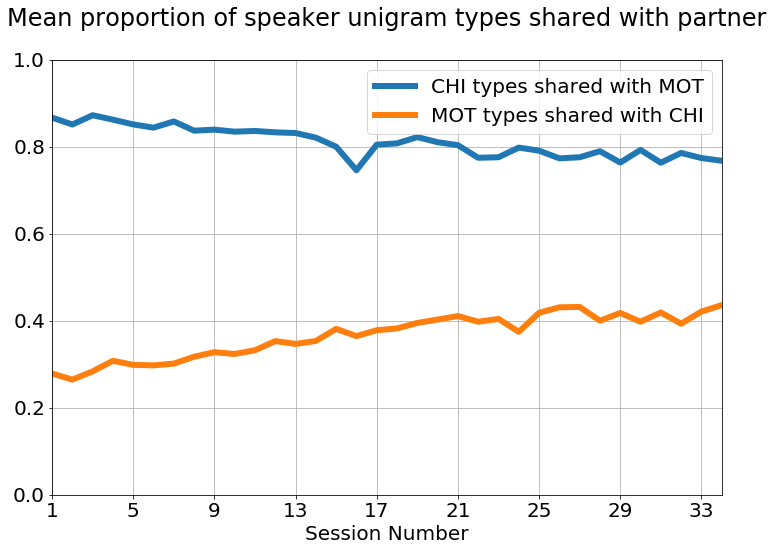

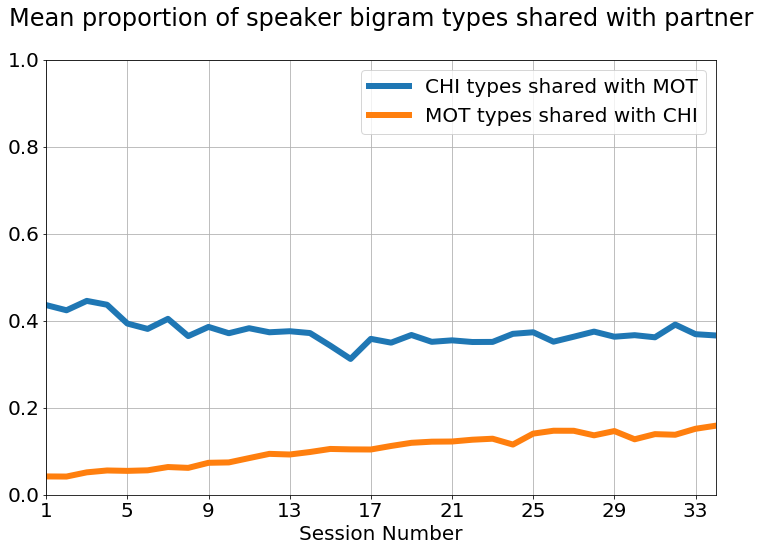

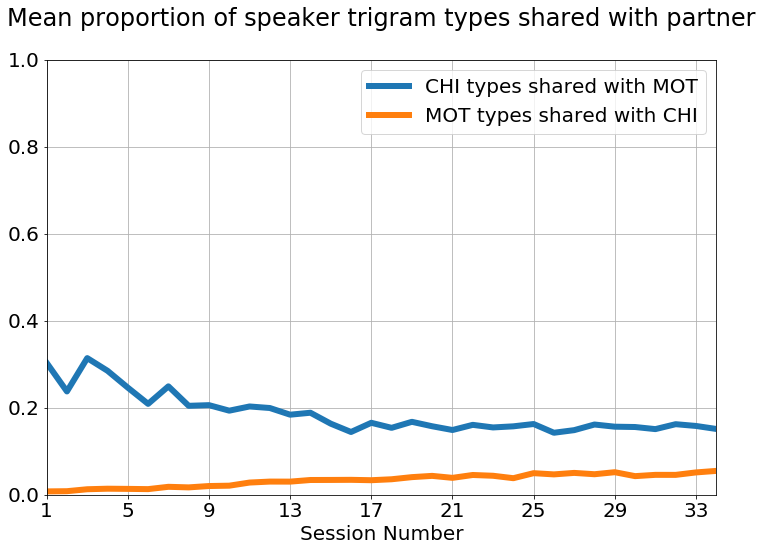

In [199]:
plt.rcParams['figure.figsize'] = 12, 8
for subset, ngram_name in zip([unigrams, bigrams, trigrams], 'uni bi tri'.split()):
    subset = subset[subset.speaker.isin(['CHI', 'MOT'])]
    zero = (
        subset
        .groupby(['corpus', 'session'])
        .apply(zeros_child_adult)
    )

    size = (
        subset
        .groupby(['corpus', 'session', 'speaker'])
        .ngram
        .apply(lambda x: x.nunique())
        .unstack()
    )

    (1 - (zero.MOT / size.CHI)).mean(level='session').plot(label='CHI types shared with MOT',
                                                           color=COLORS['CHI'])
    (1 - (zero.CHI / size.MOT)).mean(level='session').plot(label='MOT types shared with CHI',
                                                           color=COLORS['MOT'])
    vvv_format('Mean proportion of speaker {}gram types shared with partner\n'.format(ngram_name))

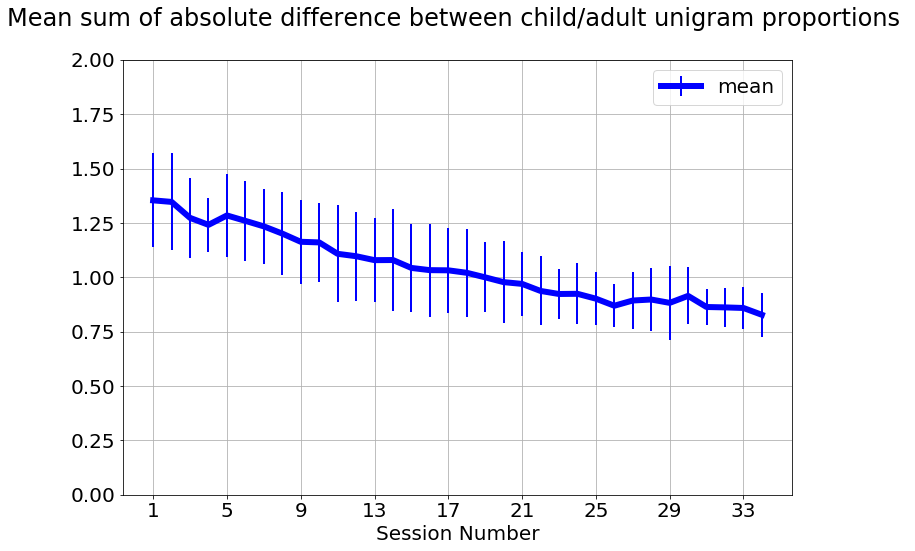

In [201]:
diffs = unigrams.groupby(['corpus', 'session']).apply(difference_child_adult)
stats = diffs.groupby(level='session').apply(lambda x: x[x > 0].describe()).unstack()
plt.errorbar(stats.index, stats['mean'], stats['std'], color='b', elinewidth=2, capsize=0)
plt.ylim(0, (stats['mean'] + stats['std'] * 1.5).max());
vvv_format
plt.rcParams['figure.figsize'] = 12, 8
vvv_format('Mean sum of absolute difference between child/adult unigram proportions \n', max=2)


# Plotting two y-scales on the same plot

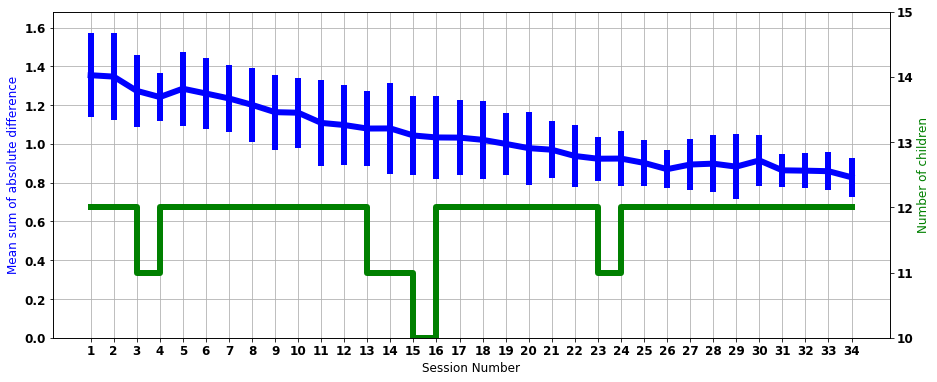

In [8]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.set_xlabel('Session Number')
ax1.set_ylabel('Mean sum of absolute difference', color='b')
ax2.set_ylabel('Number of children', color='g')

stats = diffs.groupby(level='session').apply(lambda x: x[x > 0].describe()).unstack()
ax1.errorbar(stats.index, stats['mean'], stats['std'], color='b')
ax1.set_ylim(0, (stats['mean'] + stats['std'] * 1.5).max());
ax2.step(stats.index, stats['count'], color='g')
ax2.set_ylim(10, 15)
ax1.grid()
plt.xticks(np.arange(1,35));
#per_session_plot('Mean sum of absolute difference between child/adult bigram proportions')